In [1]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm
from Dataset import LOBDataset

In [2]:
BASE_DIR = Path.cwd()

In [59]:
train_dataset_file = BASE_DIR / "datasets/train.parquet"
test_dataset_file = BASE_DIR / "datasets/valid.parquet"
learning_rate = 1e-4
nepochs = 20
batch_size = 40

In [60]:
##sequence dimension
n_steps = 1000

In [61]:
dataset_train = LOBDataset(train_dataset_file, n_steps=n_steps, labels=['t0', 't1'])
dataset_test = LOBDataset(test_dataset_file,n_steps=n_steps, labels=['t0', 't1'])

In [62]:
print(f'Number of training sequences: {dataset_train.__n_sequences__()}')
print(f'Number of testing sequences: {dataset_test.__n_sequences__()}')

Number of training sequences: 10721
Number of testing sequences: 1444


In [63]:
print(f'Number of training steps: {len(dataset_train)}')
print(f'Number of testing steps: {len(dataset_test)}')

Number of training steps: 1000
Number of testing steps: 1000


In [64]:
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=False, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [65]:
data_loader_train.dataset[32][1].shape

torch.Size([1000, 34])

In [66]:
# Define our network class using nn.Module
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Define layers for the MLP block
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size//2) ##reduce complexity divide by 2
        self.norm2 = nn.LayerNorm(input_size//2)
        self.fc2 = nn.Linear(input_size//2, output_size) ##reduce complexity divide by 2
        self.fc3 = nn.Linear(input_size, output_size)
        self.act = nn.ELU() #elementwise relu

    def forward(self, x):
        # Forward pass through the MLP block
        x = self.act(self.norm1(x))
        skip = self.fc3(x)  # Skip connection
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        return x + skip

In [67]:
class LSTM(nn.Module):
    def __init__(self, seq_len, n_features,  output_size, num_blocks=1, hidden_size=128):
        super(LSTM, self).__init__()
        # Define layers for input MLP, LSTM, residual blocks, and output linear layer
        self.input_mlp = nn.Sequential(nn.Linear(n_features, hidden_size), #expand size 
                                       nn.ELU())
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.act = nn.ELU()
    
    def forward(self, input_seq, hidden_in, mem_in):
        # Pass input sequence through the input MLP
        input_vec = self.input_mlp(input_seq)
        
        # Pass the input MLP output through the LSTM block
        output, (hidden_out, mem_out) = self.lstm(input_vec, (hidden_in, mem_in))
        
        # Pass the LSTM output through residual blocks
        x = self.act(self.res_blocks(output))
        
        # Pass the output of the residual blocks through the final linear layer
        return self.fc_out(x), hidden_out, mem_out

In [68]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

hidden_size = 128

# Create the LSTM model
lob_lstm = LSTM(seq_len=1000, n_features=32, output_size=2, hidden_size=hidden_size).to(device)

# Initialize the optimizer with Adam and specified learning rate
optimizer = optim.Adam(lob_lstm.parameters(), lr=learning_rate)

# Define the loss function as Mean Squared Error
loss_fn = nn.MSELoss()

# Initialize a list to log training losses
training_loss_logger = []

In [69]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in lob_lstm.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 170050 (Approximately 0 Million) Parameters!


In [70]:
data_loader_train.dataset[0][1][:,:].shape, data_loader_train.dataset[0][1].shape[0]

(torch.Size([1000, 34]), 1000)

In [71]:
# Run training loop for each epoch
for epoch in trange(nepochs, desc="Epochs", leave=False):
    # Set the model to training mode
    lob_lstm.train()

    for seq_id, data_seq in tqdm(data_loader_train, desc='Training', leave=False):
        # last two columns are labels
        seq_block = data_seq[:,:,:-2].to(device)
        target_seq_block = data_seq[:,:,-2:].to(device)

        hidden = torch.zeros(1, data_seq.shape[0], hidden_size, device=device)
        memory = torch.zeros(1, data_seq.shape[0], hidden_size, device=device)
        
        data_pred, hidden, memory = lob_lstm(seq_block, hidden, memory)

        loss = loss_fn(data_pred, target_seq_block)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss_logger.append(loss.item())

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

Training:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 1000, 2])
torch.Size([40, 1000, 32])
torch.Size([40, 100

In [75]:
len(training_loss_logger)

500

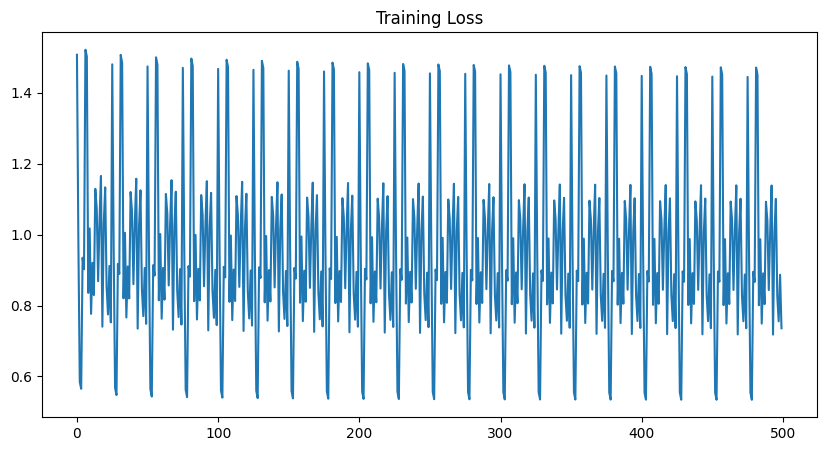

In [72]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")